In [66]:
import numpy as np
import ot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import multivariate_normal
import seaborn as sn
import pandas as pd
from pathlib import Path
from sklearn.utils import check_random_state
from scipy.spatial.distance import cdist
# User functions
from utils import W2_dist, BaseTransport, GaussianTransport, get_trajectories_for_plotting, \
                  calc_parsimony, get_desiderata

# We will be using data from  the UCI: Gas sensor array under dynamic gas mixtures Data Set
# Link: https://archive.ics.uci.edu/ml/datasets/gas+sensor+array+under+dynamic+gas+mixtures
data_dir = Path('data')

In [67]:
# Experiment hyperparamters
rng = np.random.RandomState(42)



In [68]:
# Setting so that the plots look normal even when using dark-reader
sn.set_style("whitegrid")
sn.set_context(context="paper", font_scale=2)
pal = sn.color_palette("Set1")

# Setting up specifics for plotting + saving
save_figures = True
add_legend = False
add_title = False
add_axis = False
save_parms = {'format': 'pdf','bbox_inches':'tight', 'pad_inches':0}
line_parms = {'linewidth':4, 'color':'k'}
if save_figures:  # saves all figures in a figure directory in the local directory
    figure_dir = Path('.') / 'figures' / 'adult-income-experiment'
    if not figure_dir.exists():
        figure_dir.mkdir(parents=True)

In [69]:
!dir $data_dir

zsh:1: command not found: dir


## Loading and Preprocessing the data


In [70]:
from data_utils import load_and_preprocess_logistics_data
continuous_variables_indicies = [0,1,2]
# Pick the desired dataset combination
comparison_dict = {0: [0,1], 1: [2,3], 2: [4,5]}
comparison_id = 2
# n_samples = 'balanced'
n_samples = 1000
equal_week_split = True

X, Y, feature_names = load_and_preprocess_logistics_data(
            data_dir, rng, n_samples, return_column_names=True,equal_week_split=equal_week_split, comparison_id=
            comparison_id, comparison_dict=comparison_dict)
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
print(feature_names)
print(X)
print(Y)

./00_simulate_data/Output Customer Data/customer_profile_4.csv
Comparing customer_profile_4 and customer_profile_5
Finished preprocessing logistic dataset. Split on customer_profile_4 and customer_profile_5 with resulting source shape: (1000, 3), target shape: (1000, 3).
['Connection', 'Weight', 'Unit_type']
[[11.         15.91223925  5.        ]
 [ 9.          4.19083511 10.        ]
 [ 3.         27.97612498  5.        ]
 ...
 [10.          8.09420608 30.        ]
 [11.         34.48342107 25.        ]
 [12.          8.79370241 20.        ]]
[[15.         21.93141819 24.        ]
 [ 5.         29.52515147 22.        ]
 [ 9.         30.73981751 24.        ]
 ...
 [ 4.          8.91452602 40.        ]
 [12.         16.80902273 22.        ]
 [12.         24.85228531 30.        ]]


## Performing Clustering

In [71]:
def get_mixed_variable_desiderata(X_continuous, Y_continuous, Z, standardizer, continuous_variables_indicies,
                                  n_expectation=10, inter=None, rng=None):
    rng = check_random_state(rng)
    non_continuous_variables_indicies = np.delete(np.arange(X.shape[1]), continuous_variables_indicies)
    fids = np.zeros(n_expectation)
    pars = np.zeros(n_expectation)
    for loop_idx in range(n_expectation):
        # since Z is in a pseudo continuous space, we project it to a discrete space using the phase change graph defined within Z
        # since the Z[i, j_descrete] is probability of that point being positive
        Z_projected_discrete = Z.copy()
        uniform_vars = rng.uniform(size=(Z.shape[0], len(non_continuous_variables_indicies)))
        positive_probability = Z[:, non_continuous_variables_indicies]
        # Z_projected_discrete[:, non_continuous_variables_indicies] = (uniform_vars <= positive_probability).astype(Z.dtype)
        Z_projected_continous = standardizer.transform(Z_projected_discrete)
        # Calculating fidelity
        M = cdist(Y_continuous, Z_projected_continous, 'sqeuclidean')
        a,b = ot.utils.unif(X.shape[0]), ot.utils.unif(Z.shape[0])
        fid = ot.emd2(a, b, M)
        # Calculating parsimony
        par = calc_parsimony(X_continuous, Z_projected_continous)
        # recording
        fids[loop_idx] = fid
        pars[loop_idx] = par
    fid, par = fids.mean(), pars.mean()
    if inter is not None:
        print(f'Fid: {fid:.3f}, Par: {par:.3f}, Inter: {inter}')
    return fid, par, inter

In [72]:
def mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_vars):
    non_continuous_vars = np.delete(np.arange(X_cluster.shape[1]), continuous_variables_indicies)
    X_cluster_pushed = X_cluster.copy()
    X_cluster_means = X_cluster.mean(axis=0)
    Z_cluster_means = Z_cluster.mean(axis=0)
    X_cluster_pushed[:, continuous_vars] += Z_cluster_means[continuous_vars] - X_cluster_means[continuous_vars]
    X_cluster_pushed[:, non_continuous_vars] = Z_cluster_means[non_continuous_vars]  # sets T(X_discrete) to Pr(Z_discrete = 1)
    return X_cluster_pushed

In [73]:
## Hyperparameters
max_clusters = 10

In [74]:
# Increasing the number of clusters to see the increase in fidelity and decrease in interpretability

cluster_histories = []

# fitting standardizer on our source domain
standardizer = standardizer.fit(X)

# Finding base desiderata values for T=id
X_continuous, Y_continuous = standardizer.transform(X), standardizer.transform(Y)
fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, X, standardizer, continuous_variables_indicies,
                                                n_expectation=1, inter=0, rng=rng)  # showing the base desiderata
fids = np.zeros(max_clusters+1)
fids[0] = fid
pars = np.zeros(max_clusters+1)
pars[0] = par
inters = np.zeros(max_clusters+1)
inters[0] = 0

################################################################################################################################################
T = BaseTransport(X, Y, fit=True)
Z = T.forward(X, Y)
Z_continuous = standardizer.transform(Z)

for n_clusters in range(1, max_clusters+1):
     # performs paired clustering in a continuous joint X,Z space
    cluster_labels = T._pair_clustering(X_continuous, Z=Z_continuous, n_clusters=n_clusters, rng=rng) 
    
    Z_clusters = np.zeros_like(Z)  # the final output of the cluster mean shift transport
    for cluster_idx in range(n_clusters):
        X_cluster = X[cluster_labels == cluster_idx]
        Z_cluster = Z[cluster_labels == cluster_idx]
        # A method similar for cluster mean shift transport, but with accounting for binary variables
        X_cluster_pushed = mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_variables_indicies)
        Z_clusters[cluster_labels == cluster_idx] = X_cluster_pushed
        
    # getting desiderata information
    fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, Z_clusters, standardizer, 
                                                    continuous_variables_indicies, n_expectation=30,
                                                    inter=n_clusters, rng=rng)
    fids[n_clusters] = fid
    pars[n_clusters] = par
    inters[n_clusters] = n_clusters

    cluster_record = {
        'labels': cluster_labels.copy(),
        'Z_clusters': Z_clusters.copy(),
        'n_clusters': n_clusters
    }
    cluster_histories.append(cluster_record)

Fid: 10.308, Par: 0.000, Inter: 0


Fid: 4.016, Par: 6292.467, Inter: 1
Fid: 0.336, Par: 9974.026, Inter: 2
Fid: 0.331, Par: 9976.527, Inter: 3
Fid: 0.328, Par: 9982.153, Inter: 4
Fid: 0.327, Par: 9981.411, Inter: 5
Fid: 0.281, Par: 10019.967, Inter: 6
Fid: 0.326, Par: 9983.489, Inter: 7
Fid: 0.273, Par: 10027.277, Inter: 8
Fid: 0.289, Par: 10008.787, Inter: 9
Fid: 0.290, Par: 10010.368, Inter: 10


In [75]:
# changing fidelity to be % of shift explained
def calc_percent_explained(x):
    return 100*(max_fid - x) / max_fid
max_fid = fids[0]
percent_explained = np.apply_along_axis(calc_percent_explained, 0, fids)

Results with splitting on customer_profile_4 and customer_profile_5:


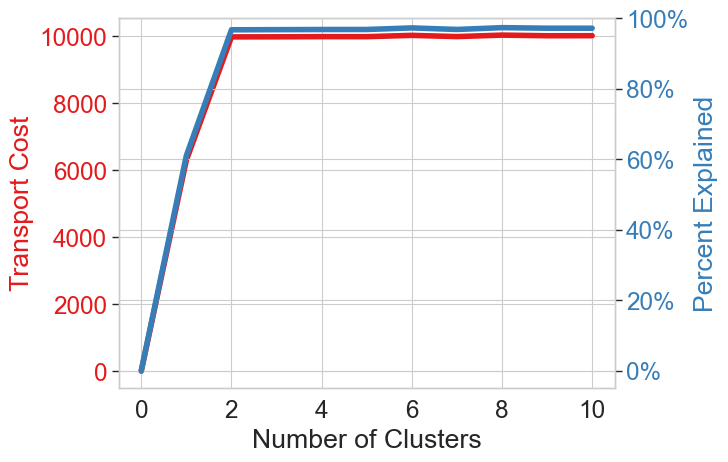

In [76]:
# Create Plot
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Number of Clusters') 
ax1.set_ylabel('Transport Cost', color = pal[0]) 
ax1.plot(np.arange(max_clusters+1), pars, color = pal[0],
         **{k:v for (k,v) in line_parms.items() if k != 'color'})  
ax1.tick_params(axis ='y', labelcolor = pal[0]) 
# Adding Twin Axes
ax2 = ax1.twinx() 
ax2.set_ylabel('Percent Explained', color = pal[1]) 
ax2.plot(np.arange(max_clusters+1), percent_explained, color = pal[1],
         **{k:v for (k,v) in line_parms.items() if k != 'color'}) 
ax2.tick_params(axis ='y', labelcolor = pal[1]) 
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_ylim(None, 100)



print(f'Results with splitting on customer_profile_{comparison_dict[comparison_id][0]} and customer_profile_{comparison_dict[comparison_id][1]}:')
if save_figures: plt.savefig(
    figure_dir / f'logitics_data_oncustomer_profile_{comparison_dict[comparison_id][0]} and customer_profile_{comparison_dict[comparison_id][1]}--clustering-results.{save_parms["format"]}',
    **save_parms
    )
plt.show()

Starting 1 cluster results:
	Cluster: 0
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_4_mean=[ 8.521 20.821 15.83 ]
		T(customer_profile_5)_mean=[ 8.196 21.767 35.586]

Starting 2 cluster results:
	Cluster: 0
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_4_mean=[ 8.49  20.424 13.203]
		T(customer_profile_5)_mean=[ 8.306 21.15  25.903]
	Cluster: 1
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_4_mean=[ 8.665 22.642 27.877]
		T(customer_profile_5)_mean=[ 7.693 24.597 80.   ]

Starting 3 cluster results:
	Cluster: 0
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_4_mean=[11.871 21.048 12.738]
		T(customer_profile_5)_mean=[11.738 21.987 25.077]
	Cluster: 1
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_4_mean=[ 8.665 22.642 27.877]
		T(customer_profile_5)_mean=[ 7.693 24.597 80.   ]
	Cluster: 2
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_4_mean=[ 4.546 19.696 13.747]
		T(customer_profile_5)_mean=[ 4.303 20.173 26.8

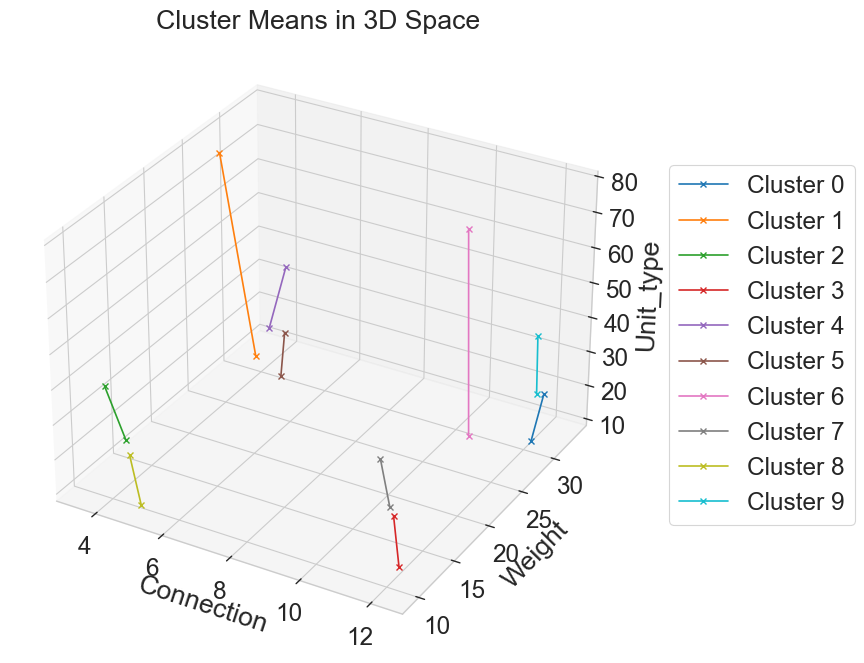

In [77]:
customer_profile_0_means = {}
customer_profile_1_means = {}
vis_clusters = max_clusters

for record_idx in range(max_clusters):
    cluster_record = cluster_histories[record_idx]
    Z_clusters = cluster_record['Z_clusters']
    labels = cluster_record['labels']
    n_clusters = cluster_record['n_clusters']
    print(f'Starting {n_clusters} cluster results:')

    src_means = []
    tgt_means = []

    tgt = f'customer_profile_{comparison_dict[comparison_id][1]}'
    src = f'customer_profile_{comparison_dict[comparison_id][0]}'
    with np.printoptions(precision=3, suppress=True):
        for cluster_idx in range(n_clusters):
            print(f'\tCluster: {cluster_idx}')
            print(f'\t\t\t\t     Names={[name[:3] for name in feature_names]}')
            src_mean = X[cluster_idx == labels].mean(axis=0)
            tgt_mean = Z_clusters[cluster_idx == labels].mean(axis=0)
            print(f'\t\t   {src}_mean={src_mean}')
            print(f'\t\tT({tgt})_mean={tgt_mean}')

            customer_profile_0_means[n_clusters] = src_means
            customer_profile_1_means[n_clusters] = tgt_means
            src_means.append(src_mean)
            tgt_means.append(tgt_mean)
        print()
print("#############################################")
# print(customer_profile_0_means)
# print(customer_profile_1_means)

# customer_profile_0_means = customer_profile_0_means[vis_clusters]
# customer_profile_1_means = customer_profile_1_means[vis_clusters]

# customer_profile_0_means = np.array(customer_profile_0_means)
# customer_profile_1_means = np.array(customer_profile_1_means)
print(customer_profile_0_means)
# print(customer_profile_1_means)
# # Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


for cluster_idx in range(vis_clusters):
    x_vals = [customer_profile_0_means[vis_clusters][cluster_idx][0], customer_profile_1_means[vis_clusters][cluster_idx][0]]
    y_vals = [customer_profile_0_means[vis_clusters][cluster_idx][1], customer_profile_1_means[vis_clusters][cluster_idx][1]]
    z_vals = [customer_profile_0_means[vis_clusters][cluster_idx][2], customer_profile_1_means[vis_clusters][cluster_idx][2]]
    print(f'x_vals {cluster_idx}')
    print(x_vals)
    print(f'y_vals {cluster_idx}')
    print(y_vals)
    print(f'z_vals {cluster_idx}')
    print(z_vals)
    ax.plot(x_vals, y_vals, z_vals, marker='x', linestyle='-', label=f'Cluster {cluster_idx}')

ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.set_zlabel(feature_names[2])
ax.set_title('Cluster Means in 3D Space')
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.show()    

[6.362, 3.169]
[8.064, 3.84]
[16.255, 7.239]
[7.616, 3.487]
[16.92, 6.784]


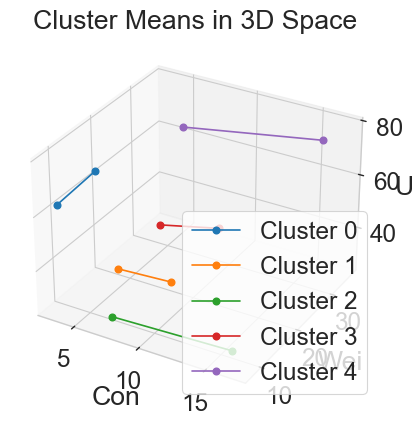

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data from the output for the first 5 clusters
names = ['Con', 'Wei', 'Uni']
customer_profile_0_mean = np.array([
    [6.362, 7.956, 80.],
    [8.064, 20.644, 25.628],
    [16.255, 8.501, 28.943],
    [7.616, 35.269, 27.368],
    [16.92, 29.714, 80.]
])

customer_profile_1_mean = np.array([
    [3.169, 8.634, 63.],
    [3.84, 20.598, 24.492],
    [7.239, 8.384, 27.535],
    [3.487, 32.879, 25.849],
    [6.784, 28.431, 73.28]
])

n_clusters = customer_profile_0_mean.shape[0]

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for cluster_idx in range(n_clusters):
    x_vals = [customer_profile_0_mean[cluster_idx, 0], customer_profile_1_mean[cluster_idx, 0]]
    y_vals = [customer_profile_0_mean[cluster_idx, 1], customer_profile_1_mean[cluster_idx, 1]]
    z_vals = [customer_profile_0_mean[cluster_idx, 2], customer_profile_1_mean[cluster_idx, 2]]
    print(x_vals)
    ax.plot(x_vals, y_vals, z_vals, marker='o', linestyle='-', label=f'Cluster {cluster_idx}')

ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_zlabel(names[2])
ax.set_title('Cluster Means in 3D Space')
ax.legend()

plt.show()
